In [287]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from scipy import interpolate


## CALCULATION ##

In [288]:
R = 8.314 # Sets R(gas constant) value in [J/(mol-K)]

In [289]:
def read_ads_data(mof, temperature): # MOF name and temp data was recorded 
    ads_data = pd.read_csv('data/{}_{}C.csv'.format(mof, temperature)) # Reads the isotherm 
    
    if (ads_data['RH[%]'])[0] == 0:
        ads_data = ads_data.drop(0) # Drops the first row if the first RH value is 0
        ads_data = ads_data.reset_index(drop=True)

    if ads_data['RH[%]'].iloc[-1] > 1:
        ads_data['P/P_0'] = ads_data['RH[%]'] / 100  # Converts the relative humidity to P/P_0 (from % to decimal)
    else:
        ads_data['P/P_0'] = ads_data['RH[%]']  # Converts the relative humidity to P/P_0 (changes name )


    ads_data["A"] = -R * (temperature+273.15) * np.log(ads_data['P/P_0']) # Calculates Polanyi adsorption potential for every point on the graph 
    
    ads_data = ads_data.drop(columns=['RH[%]']) # Gets rid of the Humidity column 
    return ads_data

In [290]:
def characteristic_curve (ads_data): # does the above lines in a function 

    ads_data = ads_data.sort_values('A') # Sorts the MOF 801 data by A values so it can be plotted and the curve can be calculated 

    n_of_A = interpolate.PchipInterpolator(ads_data['A'], ads_data['Water Uptake [kg kg-1]']) # Finds the equation of the characteristic curve 

    return n_of_A

In [291]:
def calculate_water(T,P_over_P_0,n_of_A): # Given a T and P/P_0 (RH as a fraction of 1, not a percent) 
    A = -R * (T+273.15) * np.log(P_over_P_0) # Calculate the Polanyi potential 
    Rate_H2O = n_of_A(A) # Plot A on the characteristic curve and find the rate of water adsorption 
    
    return(Rate_H2O.item()) # Return amount of water adsorption 

In [292]:
#Source for weather data for Phoenix from 2020-2021
#https://weathersight.io/timeseries

df_weather = pd.read_csv('data/Phoenix_weather_edited_final.csv') # Import csv file that contains weather data 

In [293]:
def weekly_data(week): # Given a week find the weather data 
    
    df_week = df_weather['Week'] == week # narrow the dataframe to the given week 
    T_high = df_weather[df_week]['T_max_mean[C]'].item() # looking into the weekly dataframe, pull data value 
    T_low = df_weather[df_week]['T_min_mean[C]'].item() # ""
    Dewp_high = df_weather[df_week]['Max_dewp[C]'].item() # "" 
    Dewp_low = df_weather[df_week]['Min_dewp[C]'].item() # ""
    
    return T_high, T_low, Dewp_high, Dewp_low                        

In [294]:
#Find the saturated vapor pressure from temp and dewp 
#source for formula 
#https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf

def pressure_calculations(T,T_dew): # Given a temperature and a dewpoint temp from the weather data 
    
    P_0 = 6.11 * 10**((7.5*T)/(237.3+T)) #calculate saturation pressure 
    P = 6.11 * 10**((7.5*T_dew)/(237.3+T_dew)) # calculate actual pressure
    P_over_P_0 = P/P_0 # calculate P/P_0, relative humidity as a fraction of 1 
    
    return P_over_P_0 # this should be the only value we need out of this function 

In [295]:
 
def water_daily(week,kg_MOF,n_of_A): # find mass of water depending on weekly avg weather and mass MOF
    
    T_high, T_low, Dewp_high, Dewp_low = weekly_data(week) # extract weather data 

    
    P_over_P_0_high = pressure_calculations(T_high, Dewp_high) # calculate humidity during daily high
    
    P_over_P_0_low = pressure_calculations(T_low, Dewp_low) # calculate humidity during daily low
    
    A_low = -R * (T_low+273.15) * np.log(P_over_P_0_high) # calculate polanyi potential during daily high
    
    A_high = -R * (T_high+273.15) * np.log(P_over_P_0_low) # calculate polanyi potential during daily low
    
    high_water = calculate_water(T_high, P_over_P_0_high,n_of_A)  # calculate adsorption value during daily high
    
    low_water = (calculate_water(T_low, P_over_P_0_low,n_of_A)) # calculate adsorption value during daily low (should be higher than during daily high)
    
    water_rate = low_water - high_water # compare the high and low values to find amount of water kicked off by MOF over the course of a day per kg MOF 
    
    water_mass = water_rate * kg_MOF # multiply by kg MOF to find absolute mass of water produced per day under weekly avg conditions 
    
    #print('The mass of water collected by the MOF per day during week', week, 'is',round(water_mass,4),'[kg/day]')

    return water_mass, T_high, T_low

In [296]:
def Calculate_mass(mof, data_temp, week, kg_MOF): # using MOF data at MOF name mof and data temperature temp, calculate water from given week and mass MOF

    ads_data = read_ads_data(mof, data_temp) # pull the file and calculate A values 

    n_of_A = characteristic_curve(ads_data) # create characteristic curve 

    water_mass, T_high, T_low = water_daily(week,kg_MOF,n_of_A) # pull the water mass and high and low temps to see isotherms 

    #new_isotherm(T_high, n_of_A) # view high temp isotherm 
    #new_isotherm(T_low, n_of_A) # view low temp isotherm 
    #plt.title('Difference in isotherms by daily high and low avg temp')


    return water_mass # should be what is being optimized, changing kg_MOF for a given MOF and week  


## OPTIMIZATION ##
two optimization functions

one minimizes the total mass of MOF needed to produce a certain amount of water over a day (fixed output)

one maximizes the amount of water produced by a certain amount of MOF over a day (fixed input)

In [297]:
columns = ['MOF','Data Temp', 'Water Mass [kg/day]']
MOF = ['DUT_67', 'MOF_801', 'MOF_802', 'MOF_804', 'MOF_805', 'MOF_806', 'MOF_808', 'MOF_841', 'PIZOF_2', 'UiO_66']
Data_temp = [20, 25, 20, 20, 20, 20, 20 ,20, 20, 20]

df = pd.DataFrame(columns=columns)
df['MOF'] = MOF
df['Data Temp'] = Data_temp
df

,MOF,Data Temp,Water Mass [kg/day]
0,DUT_67,20,NaN
1,MOF_801,25,NaN
2,MOF_802,20,NaN
3,MOF_804,20,NaN
4,MOF_805,20,NaN
5,MOF_806,20,NaN
6,MOF_808,20,NaN
7,MOF_841,20,NaN
8,PIZOF_2,20,NaN
9,UiO_66,20,NaN


In [298]:
def Optimize(week): # optimize the mass of MOF needed to produce a certain amount of water over a day (fixed output)

    water_mass_values = []

    kg_MOF = 0.1 # starting guess mass of each MOF 

    for i in range(len(df['MOF'])): # for each MOF in the dataframe find the amount of water produced over a day
        water_mass_MOF_i = Calculate_mass(df['MOF'][i], df['Data Temp'][i], week, kg_MOF)
        water_mass_values.append(water_mass_MOF_i)

    df['Water Mass [kg/day]'] = water_mass_values
    
    # m = 3.7 mass of water needed per day for a human [kg]

    #m = sum(water_mass_values) # find the difference between the water produced and the water needed
        
    return df


In [299]:
Optimize(1)

,MOF,Data Temp,Water Mass [kg/day]
0,DUT_67,20,0.028645
1,MOF_801,25,0.006579
2,MOF_802,20,0.002667
3,MOF_804,20,0.028182
4,MOF_805,20,0.021641
5,MOF_806,20,0.005427
6,MOF_808,20,0.028473
7,MOF_841,20,0.024750
8,PIZOF_2,20,0.000546
9,UiO_66,20,0.032872


## For viewing MOF graphs ##

In [300]:
# use water adsorption data and conditions to generate new isotherm curves by temp 
# given T, calculate all A and find ads point, then plot ads vs RH 

def new_isotherm(T,n_of_A):
    
    ads_values = []
    RH_values = []
    
    for i in range(100):
       
        A = -R * (T+273.15) * np.log((i+1)/100) # calculates polanyi potential for given T at given P/P_0

        ads = n_of_A(A).item() # finds ads value for given A value 

        RH_current = i+1

        ads_values.append(ads) # add these adsorption values to a list 

        RH_values.append(RH_current)
    
    df_new_isotherm = pd.DataFrame(ads_values, columns=['Adsorption value [kg H2O / kg MOF]']) # create dataframe with the adsorption data 

    df_new_isotherm.insert(0,'Relative Humidity',RH_values) # add RH to the dataframe 

    if df_new_isotherm['Relative Humidity'].iloc[-1] > 1:
        df_new_isotherm['P/P_0'] = df_new_isotherm['Relative Humidity'] / 100  # Converts the relative humidity to P/P_0 (from % to decimal)
    else:
        df_new_isotherm['P/P_0'] = df_new_isotherm['Relative Humidity']  # Converts the relative humidity to P/P_0 (changes name )

    df_new_isotherm["A"] = -R * (T+273.15) * np.log(df_new_isotherm['P/P_0']) # Calculates Polanyi adsorption potential for every point on the graph 

    # plots the new isotherm 
    #plt.scatter(df_new_isotherm['Relative Humidity'], df_new_isotherm['Adsorption value [kg H2O / kg MOF]'], label = (T))
    #plt.xlabel('Relative Humidity [%]')
    #plt.ylabel('Adsorption value [kg H2O / kg MOF]')
    #plt.xlim(xmin=0)
    #plt.legend()

    n_of_RH_frac = interpolate.PchipInterpolator(df_new_isotherm['P/P_0'], df_new_isotherm['Adsorption value [kg H2O / kg MOF]']) # Finds the equation of the isotherm 
    
    #plt.plot(df_new_isotherm['Relative Humidity'], n_of_RH_frac(df_new_isotherm['Relative Humidity']), label = (T))
    #plt.legend()
    
    return df_new_isotherm, n_of_RH_frac

In [301]:
def view_isotherm(mof, data_temp): # view isotherm for a given MOF and temperature 
    
    ads_data = read_ads_data(mof, data_temp) # pull the file and calculate A values 
    
    plt.title('Isotherm for {} at {}C'.format(mof, data_temp))
    plt.scatter(ads_data['P/P_0'], ads_data['Water Uptake [kg kg-1]'])
    plt.xlabel('P/P_0')
    plt.ylabel('Water Uptake [kg/kg]')
    
    

In [302]:
def view_characteristic_curve(mof, data_temp): # view the characteristic curve for a given MOF and temperature 
    
    ads_data = read_ads_data(mof, data_temp) # pull the file and calculate A values 
    
    n_of_A = characteristic_curve(ads_data) # create characteristic curve 
    
    
    plt.scatter(ads_data['A'], ads_data['Water Uptake [kg kg-1]'])
    plt.xlabel('A')
    plt.ylabel('Water Uptake [kg/kg]')
    plt.title('Characteristic curve for {} at {}C'.format(mof, data_temp))
    plt.scatter(ads_data['A'], n_of_A(ads_data['A']), label='Characteristic curve')

In [303]:
def view_mof (mof, data_temp): # view the isotherm and characteristic curve for a given MOF and temperature 
    
    view_isotherm(mof, data_temp)
    plt.show()
    view_characteristic_curve(mof, data_temp)
    plt.legend()

In [309]:
def view_all():

    MOF = ['DUT_67', 'MOF_801', 'MOF_802', 'MOF_804', 'MOF_805', 'MOF_806', 'MOF_808', 'MOF_841', 'PIZOF_2', 'UiO_66']
    Data_temp = [20, 25, 20, 20, 20, 20, 20 ,20, 20, 20]
        
    for i in range(len(MOF)):
        
        ads_data = read_ads_data(MOF[i], Data_temp[i])  
        
        plt.scatter(ads_data['P/P_0'], ads_data['Water Uptake [kg kg-1]'])

        plt.plot(ads_data['P/P_0'], ads_data['Water Uptake [kg kg-1]'], label = MOF[i])

    plt.xlabel('P/P_0')
    plt.ylabel('Water Uptake [kg/kg]')
    plt.legend()
    plt.show()

     

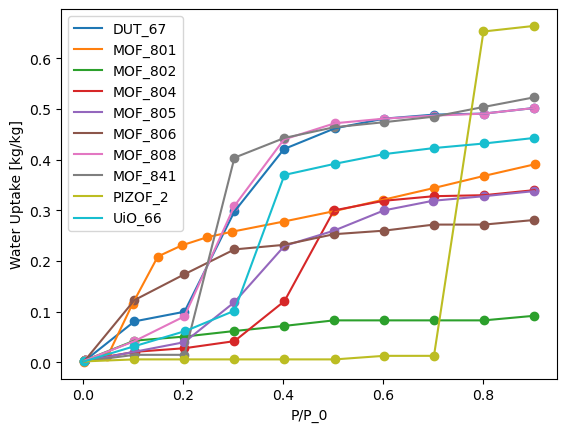

In [310]:
view_all()

## Find Error of MOF 801 when using different input temperatures compared to data values ##

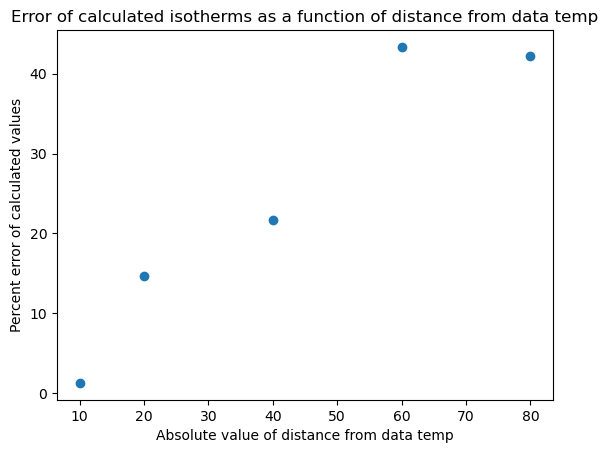

In [306]:
MOF = 'MOF_801'
ads_data = read_ads_data(MOF, 25) # pull the file and calculate A values

n_of_A = characteristic_curve(ads_data) # create characteristic curve

df_15, n_of_RH_15 = new_isotherm(15,n_of_A) # new isotherms made from the characterisric curve of the given MOF
df_25, n_of_RH_25 = new_isotherm(25,n_of_A)
df_45, n_of_RH_45 = new_isotherm(45,n_of_A)
df_65, n_of_RH_65 = new_isotherm(65,n_of_A)
df_85, n_of_RH_85 = new_isotherm(85,n_of_A)
df_105, n_of_RH_105 = new_isotherm(105,n_of_A)

ads_15 = read_ads_data(MOF, 15) # all acutal isotherm data we have  
ads_25 = read_ads_data(MOF, 25)
ads_45 = read_ads_data(MOF, 45)
ads_65 = read_ads_data(MOF, 65)
ads_85 = read_ads_data(MOF, 85)
ads_105 = read_ads_data(MOF, 105)

ads_15.insert(1,'Calculated Adsorption',n_of_RH_15(ads_15['P/P_0']),True) # add calculated adsorption to the dataframe
ads_25.insert(1,'Calculated Adsorption',n_of_RH_25(ads_25['P/P_0']),True)
ads_45.insert(1,'Calculated Adsorption',n_of_RH_45(ads_45['P/P_0']),True)
ads_65.insert(1,'Calculated Adsorption',n_of_RH_65(ads_65['P/P_0']),True)
ads_85.insert(1,'Calculated Adsorption',n_of_RH_85(ads_85['P/P_0']),True)
ads_105.insert(1,'Calculated Adsorption',n_of_RH_105(ads_105['P/P_0']),True)

ads_15['Percent Error'] = abs(ads_15['Water Uptake [kg kg-1]'] - ads_15['Calculated Adsorption']) / ads_15['Water Uptake [kg kg-1]'] * 100 # calculate percent error for each point
ads_25['Percent Error'] = abs(ads_25['Water Uptake [kg kg-1]'] - ads_25['Calculated Adsorption']) / ads_25['Water Uptake [kg kg-1]'] * 100
ads_45['Percent Error'] = abs(ads_45['Water Uptake [kg kg-1]'] - ads_45['Calculated Adsorption']) / ads_45['Water Uptake [kg kg-1]'] * 100
ads_65['Percent Error'] = abs(ads_65['Water Uptake [kg kg-1]'] - ads_65['Calculated Adsorption']) / ads_65['Water Uptake [kg kg-1]'] * 100
ads_85['Percent Error'] = abs(ads_85['Water Uptake [kg kg-1]'] - ads_85['Calculated Adsorption']) / ads_85['Water Uptake [kg kg-1]'] * 100
ads_105['Percent Error'] = abs(ads_105['Water Uptake [kg kg-1]'] - ads_105['Calculated Adsorption']) / ads_105['Water Uptake [kg kg-1]'] * 100

ads_15.drop(index = [0, 1], inplace=True) # drop the first two rows of the dataframe as they have very small mannitudes and thus very high percent error, which skews the data 
ads_25.drop(index = [0, 1], inplace=True)
ads_45.drop(index = [0, 1], inplace=True)
ads_65.drop(index = [0, 1], inplace=True)
ads_85.drop(index = [0, 1], inplace=True)
ads_105.drop(index = [0, 1], inplace=True)

err_15 = ads_15['Percent Error'].mean() # take the average of the percent error for each isotherm 
err_25 = ads_25['Percent Error'].mean()
err_45 = ads_45['Percent Error'].mean()
err_65 = ads_65['Percent Error'].mean()
err_85 = ads_85['Percent Error'].mean()
err_105 = ads_105['Percent Error'].mean()

plt.scatter([10, 20, 40, 60, 80], [err_15, err_45, err_65, err_85, err_105]) # plot error as a function of distance from data temp 
plt.xlabel('Absolute value of distance from data temp')
plt.ylabel('Percent error of calculated values')
plt.title('Error of calculated isotherms as a function of distance from data temp')
plt.show()

# also look at error as a function of RH? 



## NOTES ## 
 The 85 and 105 experimental data ends at lower RH values, and this only compares for values we possess data for. Thus, the calculated data is completely guessing (and also flattens out completely) and so the error would be much higher at those large RH values. <br> This shouldn't be a huge issue, as most if not all of the weather data shouldn't be higher than 50C or lower than -5C.

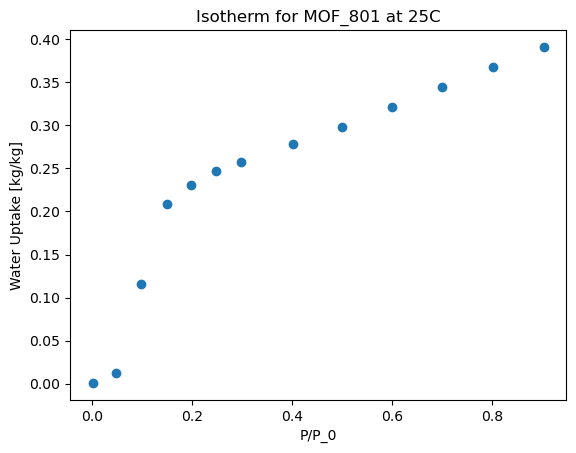

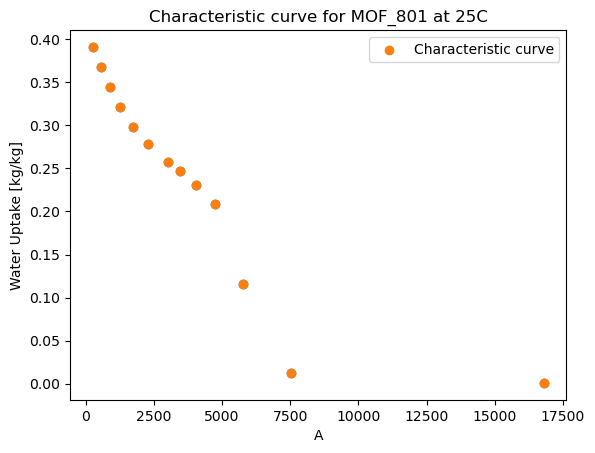

In [307]:
view_mof('MOF_801', 25)

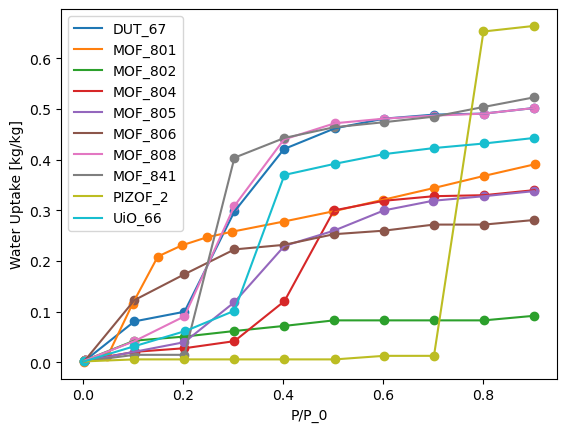

In [311]:
view_all()

In [ ]:
MOF = 'MOF_801'
ads_data = read_ads_data(MOF, 25) # pull the file and calculate A values

n_of_A = characteristic_curve(ads_data) # create characteristic curve

temps = [15, 25, 45, 65, 85, 105]
errs = [] 

for i in range(len(temps)):
    
    df_temp, n_of_RH_temp = new_isotherm(temps[i],n_of_A)
    
    ads_temp = read_ads_data(MOF, temps[i])
    
    ads_temp.insert(1,'Calculated Adsorption',n_of_RH_temp(ads_temp['P/P_0']),True)
    
    ads_temp['Percent Error'] = abs(ads_temp['Water Uptake [kg kg-1]'] - ads_temp['Calculated Adsorption']) / ads_temp['Water Uptake [kg kg-1]'] * 100
    
    ads_temp.drop(index = [0, 1], inplace=True)
    
    err_temp = ads_temp['Percent Error'].mean()
    
    errs.append(err_temp)

df_15, n_of_RH_15 = new_isotherm(15,n_of_A) # new isotherms made from the characterisric curve of the given MOF
df_25, n_of_RH_25 = new_isotherm(25,n_of_A)
df_45, n_of_RH_45 = new_isotherm(45,n_of_A)
df_65, n_of_RH_65 = new_isotherm(65,n_of_A)
df_85, n_of_RH_85 = new_isotherm(85,n_of_A)
df_105, n_of_RH_105 = new_isotherm(105,n_of_A)

ads_15 = read_ads_data(MOF, 15) # all acutal isotherm data we have  
ads_25 = read_ads_data(MOF, 25)
ads_45 = read_ads_data(MOF, 45)
ads_65 = read_ads_data(MOF, 65)
ads_85 = read_ads_data(MOF, 85)
ads_105 = read_ads_data(MOF, 105)

ads_15.insert(1,'Calculated Adsorption',n_of_RH_15(ads_15['P/P_0']),True) # add calculated adsorption to the dataframe
ads_25.insert(1,'Calculated Adsorption',n_of_RH_25(ads_25['P/P_0']),True)
ads_45.insert(1,'Calculated Adsorption',n_of_RH_45(ads_45['P/P_0']),True)
ads_65.insert(1,'Calculated Adsorption',n_of_RH_65(ads_65['P/P_0']),True)
ads_85.insert(1,'Calculated Adsorption',n_of_RH_85(ads_85['P/P_0']),True)
ads_105.insert(1,'Calculated Adsorption',n_of_RH_105(ads_105['P/P_0']),True)

ads_15['Percent Error'] = abs(ads_15['Water Uptake [kg kg-1]'] - ads_15['Calculated Adsorption']) / ads_15['Water Uptake [kg kg-1]'] * 100 # calculate percent error for each point
ads_25['Percent Error'] = abs(ads_25['Water Uptake [kg kg-1]'] - ads_25['Calculated Adsorption']) / ads_25['Water Uptake [kg kg-1]'] * 100
ads_45['Percent Error'] = abs(ads_45['Water Uptake [kg kg-1]'] - ads_45['Calculated Adsorption']) / ads_45['Water Uptake [kg kg-1]'] * 100
ads_65['Percent Error'] = abs(ads_65['Water Uptake [kg kg-1]'] - ads_65['Calculated Adsorption']) / ads_65['Water Uptake [kg kg-1]'] * 100
ads_85['Percent Error'] = abs(ads_85['Water Uptake [kg kg-1]'] - ads_85['Calculated Adsorption']) / ads_85['Water Uptake [kg kg-1]'] * 100
ads_105['Percent Error'] = abs(ads_105['Water Uptake [kg kg-1]'] - ads_105['Calculated Adsorption']) / ads_105['Water Uptake [kg kg-1]'] * 100

ads_15.drop(index = [0, 1], inplace=True) # drop the first two rows of the dataframe as they have very small mannitudes and thus very high percent error, which skews the data 
ads_25.drop(index = [0, 1], inplace=True)
ads_45.drop(index = [0, 1], inplace=True)
ads_65.drop(index = [0, 1], inplace=True)
ads_85.drop(index = [0, 1], inplace=True)
ads_105.drop(index = [0, 1], inplace=True)

err_15 = ads_15['Percent Error'].mean() # take the average of the percent error for each isotherm 
err_25 = ads_25['Percent Error'].mean()
err_45 = ads_45['Percent Error'].mean()
err_65 = ads_65['Percent Error'].mean()
err_85 = ads_85['Percent Error'].mean()
err_105 = ads_105['Percent Error'].mean()

plt.scatter([10, 20, 40, 60, 80], [err_15, err_45, err_65, err_85, err_105]) # plot error as a function of distance from data temp 
plt.xlabel('Absolute value of distance from data temp')
plt.ylabel('Percent error of calculated values')
plt.title('Error of calculated isotherms as a function of distance from data temp')
plt.show()

# also look at error as a function of RH? 

